# Wordle Tweets Dataset

## Obiettivo analitico

Obiettivo analitico: _gli utenti più attivi prestano meglio rispetto agli utenti meno attivi?_

Cominciamo importando il dataset e visualizziamo alcune informazioni.

In [100]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re
import scipy.stats as stats
import sklearn

In [101]:
wordle = pd.read_csv("WordleMegaData.csv")
wordle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140196 entries, 0 to 2140195
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   WordleID         int64  
 1   ID               int64  
 2   Created_At       object 
 3   Text             object 
 4   Source           object 
 5   UserID           float64
 6   Username         object 
 7   User_ScreenName  object 
 8   Location         object 
 9   Truncated        bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 149.0+ MB


Andiamo ora a visualizzarne le prime occorrenze.

In [102]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


## Pulizia dei dati

Per ogni carattersitica andiamo a visualizzare il numero di elementi nulli.

In [103]:
starting_rows = wordle.shape[0] # questo ci servirà dopo per vedere quanti righe sono state rimosse con la pulizia|
wordle.isnull().sum()

WordleID                0
ID                      0
Created_At              0
Text                    0
Source                  0
UserID                  0
Username               89
User_ScreenName         0
Location           573361
Truncated               0
dtype: int64

### Eliminazione duplicati ('ID')

La caratteristica 'ID' rappresenta l'ID del tweet e quindi deve essere unica. Verifichiamo che sia così.

In [104]:
num_unique_elements = wordle['ID'].nunique()
total_elements = len(wordle['ID'])

print("Number of rows where 'ID' is unique:", num_unique_elements)
print("Total number of rows:", total_elements)

Number of rows where 'ID' is unique: 2140187
Total number of rows: 2140196


Sono presenti dei duplicati, li eliminiamo.

In [105]:
wordle = wordle.drop_duplicates(subset=['ID'], keep=False)
wordle.shape

(2140178, 10)

Ora le nostre occorrenze sono uniche. 

### Eliminazione caratteristiche ('Truncated', 'Username', 'User_ScreenName', 'Location')

In [106]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


Per prima cosa eliminiamo tutti i tweet troncati proprio perchè il loro contenuto informativo è incompleto e rimuoviamo la colonna.

L'informazione più affidabile su cui basarsi per identificare un utente all'interno del dataset è UserID. L'assenza di valori nulli per questo attributo ci fornisce maggiore sicurezza. Possiamo allora fare a meno delle colonne Username e User_ScreenName che possono contenere identificativi non unici e modificabili da parte dell'utente nel tempo.

Notiamo inoltre che la colonna Location contiene a sua volta valori nulli o valori errati. Come ulteriore verifica, su Kaggle ci viene suggerito che il 27% dei valori è nullo, il 72% non viene associato a una macrocategoria, mentre l'1% dei tweet risulta provenire dagli Stati Uniti. Avendo già verificato a nostra volta che il numero di valori nulli per questa caratteristica è elevato, eliminiamo la colonna. 

In [107]:
wordle = wordle[wordle['Truncated'] != True]
wordle.drop(columns=['Username', 'User_ScreenName', 'Location', 'Truncated'], inplace=True)

### Creazione caratteristica 'Attempts' e 'Hard Mode'

Nel dataset è ricorrente la sequenza 'Wordle XXX X/6' dove le tre cifre centrali indicano il wordleID mentre la frazione fa riferimento al numero di tentativi che l'utente ha eseguito per indovinare la parola o prima di abbandonare la partita. Se la sequenza 'Wordle XXX X/6' termina con un asterisco, significa che la partita è stata eseguita nella modalità 'Hard Mode'.

Andiamo a effettuare una pulizia del testo, mantenendo solamente le informazioni riguardanti la partita a wordle. 
Dal testo generiamo un'altra colonna 'Attempts' che rappresenta il numero di tentativi effettuati per indovinare la parola oppure X o x nel caso di fallimento.

In [108]:
number_pattern = re.compile(r'(Wordle) (\d{3}) (([1-6Xx])\/6)')

#la funzione search restituisce la prima occorrenza del pattern, mentre la funzione findall ne preleva tutte le occorrenze
def extract_attempts(row):
    matches = number_pattern.findall(row)
    attempts = [match[2].replace('/6', '') for match in matches]
    return attempts if attempts else np.nan

wordle['Attempts'] = wordle['Text'].apply(extract_attempts)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,[3]
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,[4]
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,[3]
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,[3]
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,[3]


Visualizziamo le righe dove ci sono più occorrenze per attempts.

In [109]:
rows_with_multiple_occurrences = wordle[wordle['Attempts'].str.len() > 1]
print(len(rows_with_multiple_occurrences))

496


Poichè solamente 496 campioni contengono più occorrenze, li eliminiamo. 

In [110]:
wordle = wordle[(wordle['Attempts'].str.len() == 1) | (wordle['Attempts'].isna())]
wordle.loc[wordle['Attempts'].notna(), 'Attempts'] = wordle.loc[wordle['Attempts'].notna(), 'Attempts'].str[0].astype(str)

Ora che abbiamo la certezza che Attempts, se presente, sia univoco per ogni campione, avendo eliminato le situazioni di ambiguità, creiamo una nuova caratteristica. Quest'ultima indicherà se è stata selezionata o meno l'Hard Mode. 

In [111]:
hard_mode = wordle['Text'].str.extract(r'(Wordle) (\d{3}) (([1-6Xx])\/6\*)')
wordle['Hard Mode'] = hard_mode.iloc[:, 0].notnull()
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False


In [112]:
hard_mode_count = wordle['Hard Mode'].sum()
print("Number of True values in Hard Mode column:", hard_mode_count)

Number of True values in Hard Mode column: 128097


### Creazione caratteristica 'Match' ed eliminazione della caratteristica 'Text'

Per estrarre ulteriori informazioni possiamo affidarci alle emoji riportate nei tweet.

Le informazioni associate a ciascuna emoji sono le seguenti:
- ⬛ o ⬜ indicano che la lettera non è presente nella parola
- 🟨 indica che la lettera è corretta ma non la sua posizione
- 🟩 indica che la lettera è corretta e anche la sua posizione

Estraiamo dal campo Text le emoji e creiamo una colonna Match.

In [113]:
colored_squares_pattern = re.compile(r'(\n[🟨🟩⬛⬜]{5})', flags=re.UNICODE)

def filter_text(row):
    matches = colored_squares_pattern.findall(row['Text'])
    if not matches:
        return np.nan 
    filtered_text = ''.join(''.join(element for element in match) for match in matches).replace('\n', '')
    return filtered_text

wordle['Match'] = wordle.apply(filter_text, axis=1)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,🟨🟨⬛⬛⬛🟨⬛🟨⬛🟩🟩🟩🟩🟩🟩
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,⬛⬛⬛⬛🟩⬛⬛⬛⬛🟩⬛🟩⬛⬛🟩🟩🟩🟩🟩🟩
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,⬛⬛⬛⬛🟩⬛⬛🟩⬛🟩🟩🟩🟩🟩🟩
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,⬛⬛⬛🟨⬛⬛🟨⬛⬛🟩🟩🟩🟩🟩🟩
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,⬛🟨⬛⬛⬛🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩


In [114]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      45315
Hard Mode         0
Match         28700
dtype: int64

Match ha circa 30000 valori nulli. Non potendo integrare i valori dove Match è nullo, eliminiamo i campioni coinvolti. 

In [115]:
wordle = wordle.dropna(subset=['Match'])
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39690
Hard Mode         0
Match             0
dtype: int64

Per semplicità trasformiamo Match in un array dove ogni elemento è un tentativo.

In [116]:
wordle['Match'] = wordle['Match'].astype(str)
wordle['Match'] = wordle['Match'].apply(lambda x: [x[i:i+5] for i in range(0, len(x), 5)])

Eliminiamo le occorrenze dove Match contiene più di 6 elementi e quindi dove è certamente presente più di una occorrenza di una partita.

In [117]:
wordle = wordle[wordle['Match'].apply(len) <= 6]

In [118]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


In [119]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39538
Hard Mode         0
Match             0
dtype: int64

Eliminiamo ora la caratteristica 'Text' da cui abbiamo estratto tutte le informazioni che ci servivano.

In [120]:
wordle.drop(columns=['Text'], inplace=True)

### Eliminazione valori nulli di 'Attempts' e verifica di coerenza con 'Match'

Eliminiamo i campioni dove Attempts è NaN.

In [121]:
wordle = wordle.dropna(subset=['Attempts'])
wordle.isnull().sum()

WordleID      0
ID            0
Created_At    0
Source        0
UserID        0
Attempts      0
Hard Mode     0
Match         0
dtype: int64

In Attempts 'x' o 'X' indicano una partita persa o in cui l'utente si è arreso prima di terminare. Vorremo realizzare una colonna 'Win' che tenga traccia delle partite vinte e perse. Tuttavia preferiamo estrarre questa informazione dalla caratteristica 'Match' in un secondo momento a seguito di un controllo che ci garantirà maggiore affidabilità circa le vittorie. Pertanto, sostituiamo 'x' e 'X' con il numero equivalente di tentativi nella partita, ossia la lunghezza dell'array in 'Match'.

In [122]:
#wordle['Attempts'].replace('X', '6')
#wordle['Attempts'].replace('x', '6')

# Function to replace 'x' or 'X' in Attempts based on the length of Match
def replace_attempts(row):
    attempts = row['Attempts']
    match_length = len(row['Match'])
    if attempts.lower() == 'x' or attempts.upper() == 'X':
        return str(match_length)
    else:
        return attempts

# Apply the function to replace 'x' or 'X' in Attempts
wordle['Attempts'] = wordle.apply(replace_attempts, axis = 1)


Verifichiamo che i nostri dati siano coerenti. Per prima cosa verifichiamo che per ogni campione il numero di gruppi da 5 quadrati consecutivi appena estratto sia uguale al valore contenuto nella caratteristica 'Attempts'. Se i due non sono uguali può significare che la partita riportata nel tweet era sbagliata, che nel tweet è riportata più di una partita o che Attempts non rispecchia la partita presente nel tweet.

In [123]:
wordle['Attempts'] = wordle['Attempts'].astype(int)

def verify_length(row):
    # Get the length of the 'Text' array
    text_length = len(row['Match'])
    
    # Get the value in the 'Attempts' column
    attempts = row['Attempts']
    
    # Check if the lengths match
    return text_length != attempts

# Count the number of rows where lengths do not match
num_mismatched_rows = wordle.apply(verify_length, axis=1).sum()

print("Number of rows where the number of elements in 'Match' is not equal to 'Attempts':", num_mismatched_rows)
print("Total number of rows:", wordle.shape[0])

Number of rows where the number of elements in 'Match' is not equal to 'Attempts': 8104
Total number of rows: 2030551


Eliminiamo le righe dove c'è incoerenza. 

In [124]:
# Create a boolean mask indicating whether the number of elements in 'Text' matches 'Attempts'
mask = wordle.apply(lambda row: len(row['Match']) == row['Attempts'], axis=1)

# Drop the rows where the number of elements in 'Text' does not match 'Attempts'
wordle = wordle[mask]

# Print the resulting DataFrame
print(wordle.shape[0])
wordle.head()

2022447


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


### Verifica corretteza 'Match'

Ora che sappiamo che il numero di gruppi di quadrati consecutivi coincide sempre col numero di tentativi, eliminiamo tutte quelle righe che contengono valori sbagliati del campo 'Match' (come ad esempio 6 righe di 5 quadrati tutti verdi). 

In [125]:
def meets_conditions(row):
    # Check if any element in 'Text' contains five 🟩
    for i, text in enumerate(row['Match']):
        if text.count('🟩') == 5: 
            # Check if it's the last element of the array
            if i == len(row['Match']) - 1:
                # If the condition is met and it's the last element, check if it's the only one
                num_matching_elements = sum(1 for t in row['Match'] if t.count('🟩') == 5) 
                if num_matching_elements == 1:
                    return True
                else:
                    return False
            else:
                return False
    # If no element contains five 🟩, return True
    return True

wrong_rows = wordle[~wordle.apply(meets_conditions, axis=1)]

# Apply the function to each row of the DataFrame to filter out rows that don't meet the conditions
wordle = wordle[wordle.apply(meets_conditions, axis=1)]
print(wordle.shape[0])

2022414


In [126]:
wrong_rows.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
29140,255,1498772741654261763,2022-03-01 21:30:42+00:00,Twitter for Android,1.420928e+18,5,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
44728,256,1499150725229826052,2022-03-02 22:32:40+00:00,Twitter for iPhone,1.190034e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45083,256,1499149451822260228,2022-03-02 22:27:36+00:00,Twitter for iPhone,1.481837e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45186,256,1499149042852397057,2022-03-02 22:25:59+00:00,Twitter for iPhone,1.456332e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
54251,256,1499116431148945410,2022-03-02 20:16:24+00:00,Twitter Web App,1.021135e+18,6,False,"[⬛🟩🟩🟩🟩, 🟩🟩🟨🟨🟨, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, ⬛🟩⬛⬛🟩]"


Abbiamo effettivamente eliminato dei campioni errati. 

### Creazione caratteristica 'Win'

Creiamo una colonna 'Win' che ci indichi se una partita è stata vinta o persa. 

In [127]:
def verify_winning_rows(row):
    # Get the last element of the 'Text_Array'
    last_element = row['Match'][-1]
        
    # Check if the last element contains five 🟩 
    if last_element.count('🟩') == 5:
            # Check if the last element is the only one containing five 🟩 
            num_matching_elements = sum(1 for text in row['Match'] if text.count('🟩') == 5)
            return num_matching_elements == 1
    return False

wordle.loc[:, 'Win'] = wordle.apply(verify_winning_rows, axis=1)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True


### Verifica unicità della coppia <'WordleID', 'UserID'>

Le regole di Wordle sono le seguenti:

  -  è possibile giocare un solo puzzle al giorno
  
  -  tutti giocano allo stesso puzzle 
  
Dobbiamo quindi verificare che per ciascun WordleID non ci siano più ricorrenze di uno stesso UserID. Nel caso siano presenti più occorrenze, non abbiamo strumenti che ci permettano con certezza di identificare quale occorrenza sia quella corretta da considerare, perciò poichè ambigui li eliminiamo.

In [128]:
wordle.drop_duplicates(subset=['UserID', 'WordleID'], keep=False, inplace=True)

### Pulizia caratteristica 'Source'

Come ultima cosa andiamo a controllare la caratteristica 'Source', che indica il client di Twitter dal quale è stato fatto il tweet, iniziamo controllando i primi 15 valori che appaiono più volte.

In [129]:
occorrenze_clients = wordle['Source'].value_counts()
print(occorrenze_clients[:15])

Twitter for iPhone         1126618
Twitter for Android         510276
Twitter Web App             266692
Twitter for iPad             55444
TweetDeck                    15274
Tweetbot for iΟS             10608
Echofon                       3448
Twitterrific for iOS          2184
Twitter for Mac               1465
TweetCaster for Android       1152
Fenix 2                        861
Flamingo for Android           627
Plume for Android              608
Tweetbot for Mac               601
Talon Android                  547
Name: Source, dtype: int64


Considerando la grande dimensione del dataset, decidiamo di etichettare come 'Other' tutti quei client che hanno un numero di occorrenze minore di 15 mila

In [130]:
valori_other = occorrenze_clients[occorrenze_clients < 15000].index
wordle.loc[wordle['Source'].isin(valori_other), 'Source'] = 'Other'
print(wordle['Source'].value_counts())

Twitter for iPhone     1126618
Twitter for Android     510276
Twitter Web App         266692
Twitter for iPad         55444
Other                    29324
TweetDeck                15274
Name: Source, dtype: int64


Andiamo a vedere quanti dati abbiamo "perso" durante la pulizia

In [131]:
lost_lines = starting_rows - wordle.shape[0]
lost_percentage = ((100*lost_lines)/starting_rows)

print(f'Abbiamo rimosso un totale di {lost_lines} righe, che corrispondono al {round(lost_percentage,1)}% delle righe iniziali')

Abbiamo rimosso un totale di 136568 righe, che corrispondono al 6.4% delle righe iniziali


## Visualizzazione dei dati

Per realizzare una rappresentazione OLAP utilizziamo i seguenti parametri:
- Attività di un utente (tanti tweet caratterizzano un utente molto attivo, pochi tweet uno poco attivo)
- Difficoltà di una parola (sulla base della media dei tentativi e del numero di partite perse)
- Orario del tweet (mattino, pomeriggio, sera e notte)

Creiamo una caratteristica _UserActivity_ che per ciascun utente ci indichi quanto questo è attivo. Categorizziamo gli utenti sulla base del numero di tweet da essi pubblicati e il cui contenuto è la propria partita su wordle. 
Per non raggruppare in maniera sbilanciata, facciamoci guidare nella scelta dal seguente boxplot.

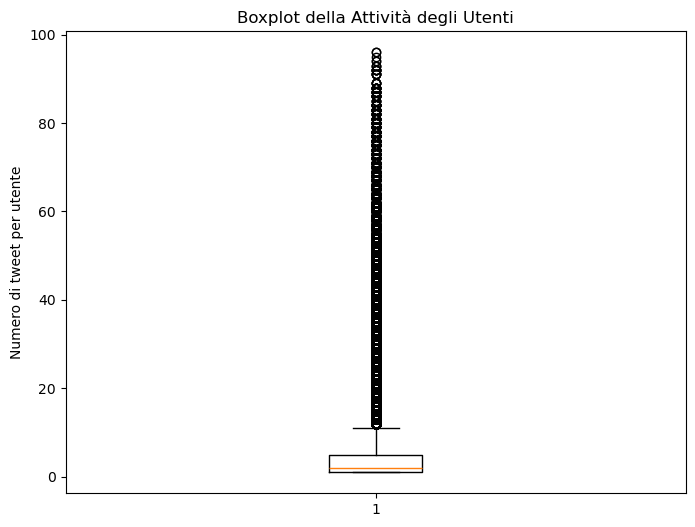

In [132]:
user_activity = wordle['UserID'].value_counts()

plt.figure(figsize=(8, 6))
plt.boxplot(user_activity)
plt.title('Boxplot della Attività degli Utenti')
plt.ylabel('Numero di tweet per utente')
plt.show()

Ricaviamoci con precisione i valori di media, varianza, moda e mediana. 

In [133]:
print("Mean: ", user_activity.mean())
print("Variance: ", user_activity.var())
print("Mode: ", user_activity.mode())
print("Median: ", user_activity.median())

Mean:  4.928695301372862
Variance:  68.99858824541084
Mode:  0    1
Name: UserID, dtype: int64
Median:  2.0


In [134]:
print(user_activity)

2.778092e+09    96
5.185310e+08    96
7.569270e+17    95
1.963916e+08    94
1.424114e+18    94
                ..
1.265912e+18     1
8.513366e+17     1
1.462236e+08     1
1.492807e+18     1
7.109468e+17     1
Name: UserID, Length: 406523, dtype: int64


Contando i valori unici di WordleID siamo in grado di risalire al numero complessivo di parole del giorno presenti nel nostro dataset.

In [135]:
unique_wordle_ids = wordle['WordleID'].nunique()
print("Number of unique WordleIDs:", unique_wordle_ids)

Number of unique WordleIDs: 107


Nel nostro dataset sono presenti 107 parole da indovinare. Il fatto che il numero massimo di partite condivise da un utente sia 96, ossia un valore inferiore a 107 dimostra che i nostri dati sono coerenti.

Usiamo la seguente quantizzazione per il numero di condivisioni di ciascun utente:
1. Low Activity = [1, 2];
2. Medium Activity = [3, 7];
3. High Activity = [8, 49];
4. Very High Activity = [50, 107];

In [136]:
bins = [0, 3, 8, 50, 107]
labels = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']

user_macrocategories = pd.cut(user_activity, bins=bins, labels=labels)

wordle = wordle.merge(user_macrocategories.rename('UserActivity'), left_on='UserID', right_index=True)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,36816757.0,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,482591014.0,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,High Activity
73387,257,1499477529232617480,2022-03-03 20:11:16+00:00,Twitter for iPhone,482591014.0,5,False,"[⬛🟨⬛⬛⬛, ⬛⬛🟩🟨⬛, ⬛🟨🟩⬛⬛, ⬛🟨🟩🟨⬛, 🟩🟩🟩🟩🟩]",True,High Activity
133607,260,1500563244653678592,2022-03-06 20:05:31+00:00,Twitter for iPhone,482591014.0,5,False,"[⬛⬛⬛⬛⬛, ⬛🟩⬛⬛⬛, ⬛🟩⬛⬛🟨, 🟩🟩🟩🟩⬛, 🟩🟩🟩🟩🟩]",True,High Activity
161136,262,1501340165331202049,2022-03-08 23:32:43+00:00,Twitter for iPhone,482591014.0,5,False,"[⬛⬛⬛⬛🟨, ⬛⬛⬛⬛🟨, ⬛⬛🟩🟨🟩, 🟩⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True,High Activity


Definiamo un'altra quantizzazione in base al periodo della giornata in cui è stato fatto il tweet:
1. Morning = [5, 12];
2. Afternoon = [12, 19];
3. Evening = [19, 24];
4. Night = [0, 5].

In [137]:
wordle['Created_At'] = pd.to_datetime(wordle['Created_At'])

bins = [0, 5, 12, 19, 24]
labels = ['Night','Morning','Afternoon','Evening']

wordle['TimeOfDay'] = pd.cut(wordle['Created_At'].dt.hour, bins=bins, labels=labels, right=False)

n = 5
wordle.sample(n).sort_values(by='TimeOfDay').head(n)

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity,TimeOfDay
1354061,322,1522959791672676352,2022-05-07 15:21:24+00:00,Twitter for iPhone,2.509545e+07,3,False,"[🟨⬛⬛🟨⬛, 🟨⬛⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity,Afternoon
819797,294,1512827298239574016,2022-04-09 16:18:29+00:00,Twitter for iPhone,1.313634e+18,2,True,"[⬜🟨⬜⬜🟨, 🟩🟩🟩🟩🟩]",True,Low Activity,Afternoon
1616463,339,1529092170631720962,2022-05-24 13:29:17+00:00,Twitter for Android,2.861292e+09,5,False,"[⬜⬜⬜⬜⬜, ⬜⬜🟨⬜⬜, ⬜🟨🟨⬜⬜, ⬜🟩🟨🟩🟩, 🟩🟩🟩🟩🟩]",True,High Activity,Afternoon
1709545,348,1532382809209307136,2022-06-02 15:25:06+00:00,Twitter for iPhone,1.928416e+08,3,False,"[⬛⬛⬛⬛⬛, 🟨⬛⬛⬛🟨, 🟩🟩🟩🟩🟩]",True,High Activity,Afternoon
1569042,335,1527690857612292106,2022-05-20 16:40:58+00:00,Twitter Web App,1.706203e+09,6,False,"[⬜⬜⬜🟨⬜, ⬜🟨🟨⬜🟨, 🟨🟩🟨⬜⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",False,Low Activity,Afternoon


Desideriamo conoscere in quali fasce orarie gli utenti sono più attivi. Visualizziamo questa informazione con un bar plot.

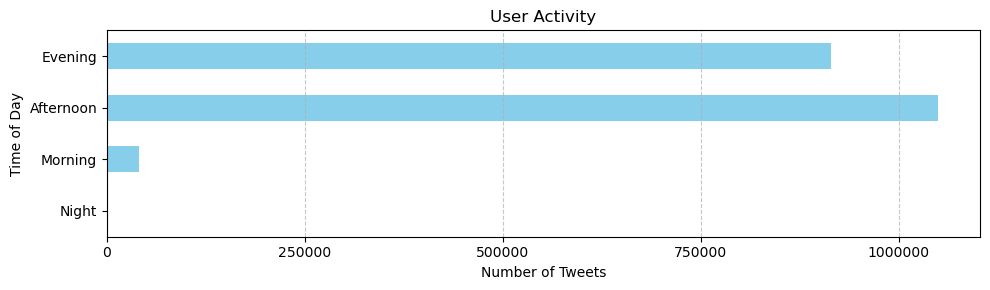

In [138]:
activity_by_time = wordle['TimeOfDay'].value_counts()

activity_by_time = activity_by_time.reindex(labels)

plt.figure(figsize=(10, 3))
activity_by_time.plot(kind='barh', color='skyblue')

# Set tick positions and labels for x-axis
tick_positions = [0, 250000, 500000, 750000, 1000000]
tick_labels = [str(val) for val in tick_positions]

plt.xticks(tick_positions, tick_labels)

plt.title('User Activity')
plt.ylabel('Time of Day')
plt.xlabel('Number of Tweets')

plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

La nuova parola del giorno viene rilasciata a mezzanotte della propria ora locale, nel nostro dataset però nessun utente ha condiviso la propria partita nella fascia oraria notturna.

Per assegnare a ciascuna parola un livello di difficoltà:
- Nel caso in cui il numero di sconfitte per quella parola sia maggiore di 2.2 volte il valore medio del numero di sconfitte, la parola è '__Very Hard__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 1 e 4.0 e la partita è vinta, la parola è '__Easy__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.0 e 4.5 e la partita è vinta, la parola è '__Medium__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.5 e 6 e la partita è vinta, la parola è '__Hard__'

In [139]:
mean_attempts = wordle[wordle['Win']].groupby('WordleID')['Attempts'].mean()

# Categorize WordleIDs based on the criteria
def categorize_difficulty(mean_attempt):
    if mean_attempt >= 4.5:
        return 'Hard'
    elif mean_attempt >= 4.0:
        return 'Medium'
    else:
        return 'Easy'

# Apply the categorization function to each WordleID
wordle['Difficulty'] = wordle['WordleID'].map(mean_attempts).apply(categorize_difficulty)

# Calculate the overall ratio of lost games to total games in the entire DataFrame
overall_lost_games_ratio = wordle[~wordle['Win']].shape[0] / wordle.shape[0]

# Define a function to check if the condition is met for a specific WordleID
def should_update_difficulty(wordle_id):
    wordle_subset = wordle[wordle['WordleID'] == wordle_id]
    lost_games_ratio = wordle_subset[~wordle_subset['Win']].shape[0] / wordle_subset.shape[0]
    return lost_games_ratio > 2.2*overall_lost_games_ratio

# Iterate over each unique WordleID
for unique_id in wordle['WordleID'].unique():
    # Check if the condition is met for the current WordleID
    if should_update_difficulty(unique_id):
        # Update the 'Difficulty' column for rows with the current WordleID
        wordle.loc[wordle['WordleID'] == unique_id, 'Difficulty'] = 'Very Hard'

In [140]:
num_very_hard = (wordle['Difficulty'] == 'Very Hard').sum()

# Print the number of rows
print("Number of rows with Difficulty 'Very Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Hard').sum()
print("Number of rows with Difficulty 'Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Medium').sum()
print("Number of rows with Difficulty 'Medium':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Easy').sum()
print("Number of rows with Difficulty 'Easy':", num_very_hard)

Number of rows with Difficulty 'Very Hard': 182957
Number of rows with Difficulty 'Hard': 167879
Number of rows with Difficulty 'Medium': 824939
Number of rows with Difficulty 'Easy': 827853


Verifichiamo di non aver introdotto per errore valori nulli in questa fase.

In [141]:
print(wordle.isnull().sum())

WordleID        0
ID              0
Created_At      0
Source          0
UserID          0
Attempts        0
Hard Mode       0
Match           0
Win             0
UserActivity    0
TimeOfDay       0
Difficulty      0
dtype: int64


Tracciamo un grafico a torta per vedere la distribuzione delle parole in base alla difficoltà

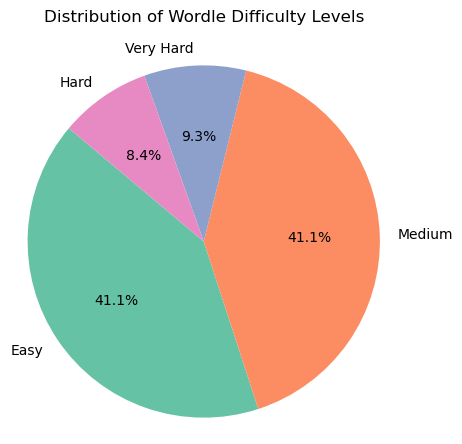

In [142]:
wordle_difficulty = wordle.groupby('WordleID')['Difficulty'].first().reset_index()
difficulty_counts = wordle_difficulty['Difficulty'].value_counts()

colors = plt.cm.Set2.colors

plt.figure(figsize=(5, 5))
plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', startangle=140, colors = colors)
plt.title('Distribution of Wordle Difficulty Levels', pad=20)
plt.axis('equal')  
plt.show()


Un'altra informazione che può risultare utile da visualizzare è da quale dispositivo vengono fatti i tweet.
Andiamo a visualizzare intanto i valori unici che assume la colonna 'Source' 

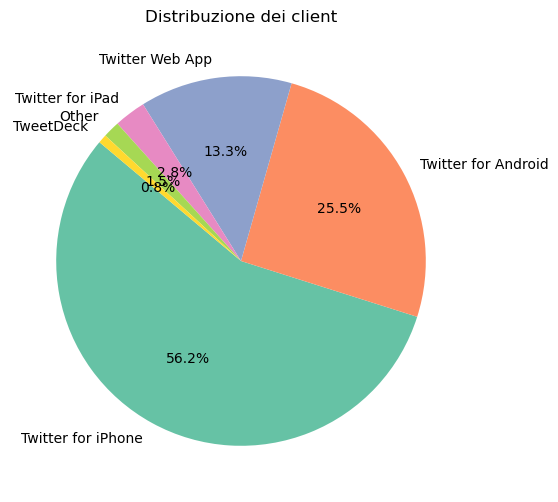

In [143]:
valori_client = wordle['Source'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(valori_client, labels=valori_client.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribuzione dei client')
plt.ylabel('')
plt.show()

Si può vedere che il client più utilizzato è l'app di Twitter per iPhone, quindi gli iPhone users sono quelli che nella popolazione twittano di più. 

### OLAP

Ora che è terminata la preparazione dei dati, procediamo con la analisi OLAP.

In [144]:
quantize_user_activity = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']
quantize_time_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']
quantize_difficulty = ['Easy', 'Medium', 'Hard', 'Very Hard']

OLAP = np.zeros((len(quantize_user_activity),len(quantize_time_of_day),len(quantize_difficulty)))
for z in range(len(quantize_user_activity)):
    for j in range(len(quantize_time_of_day)):
        for i in range(len(quantize_difficulty)):
            # Filter dataframe
            filtered_data = wordle[(wordle['UserActivity'] == quantize_user_activity[z]) &
                                   (wordle['TimeOfDay'] == quantize_time_of_day[j]) &
                                   (wordle['Difficulty'] == quantize_difficulty[i])]
            # Calculate number of wins
            wins = filtered_data['Win'].sum()
            
            # Calculate number of matches
            matches = len(filtered_data)
            
            # Compute ratio of wins to matches (avoid division by zero)
            ratio = wins / matches * 100 if matches > 0 else np.nan
            
            # Populate OLAP cube
            OLAP[z, j, i] = ratio
OLAP

array([[[ 98.80418535,  98.25673534,          nan,  90.98497496],
        [ 98.50791395,  97.49666597,  93.86846457,  81.53318791],
        [ 98.62552473,  97.53104417,  95.23254685,  81.48188743],
        [         nan,          nan,          nan,          nan]],

       [[ 99.13232104,  98.25394135,          nan,  94.27580225],
        [ 98.90874998,  97.90839328,  95.49801952,  89.95271178],
        [ 98.9099637 ,  97.86641025,  96.38739431,  91.04007815],
        [         nan,          nan,          nan,          nan]],

       [[ 99.44618793,  98.90401672,          nan,  95.50115779],
        [ 99.20602515,  98.50027315,  96.70273328,  89.83644025],
        [ 99.09471977,  98.3891017 ,  96.87621207,  90.20856992],
        [         nan,          nan,          nan,          nan]],

       [[ 98.27586207,  98.48484848,          nan, 100.        ],
        [ 99.23509087,  98.54642331,  97.20637185,  87.93445879],
        [ 99.31563511,  98.49756098,  97.30397663,  88.5583524 ],
    

Facciamo uno slicing rispetto a TimeOfDay. Poichè la sera e il pomeriggio sono le fasce orarie di picco le prediligiamo. 

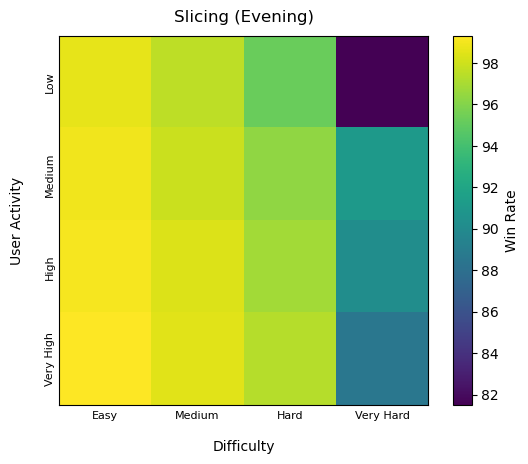

In [145]:
plt.imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=25)
plt.title('Slicing (Evening)', pad=10)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show() 

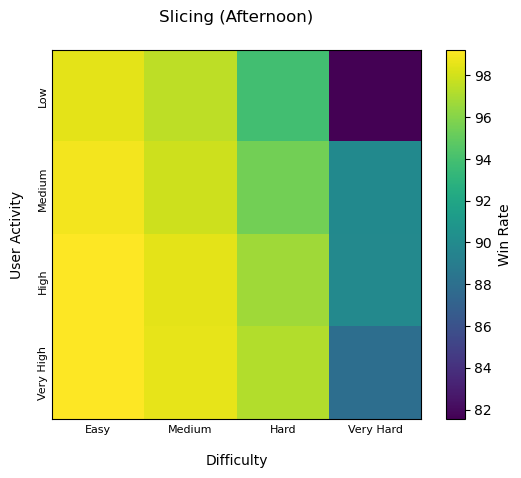

In [146]:
plt.imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Afternoon)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

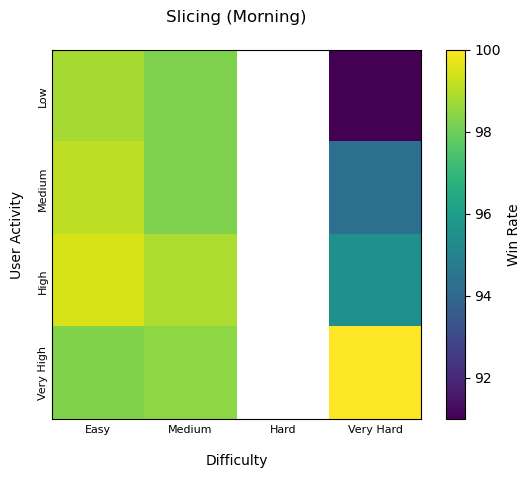

In [147]:
plt.imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Morning)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

Possiamo notare come, in tutte le visualizzazioni sopra, il tasso di vittoria degli utenti medio attivi, attivi e molto attivi sia generalmente maggiore del tasso di vittoria del utenti poco attivi, in particolare in caso di parole molto difficili.

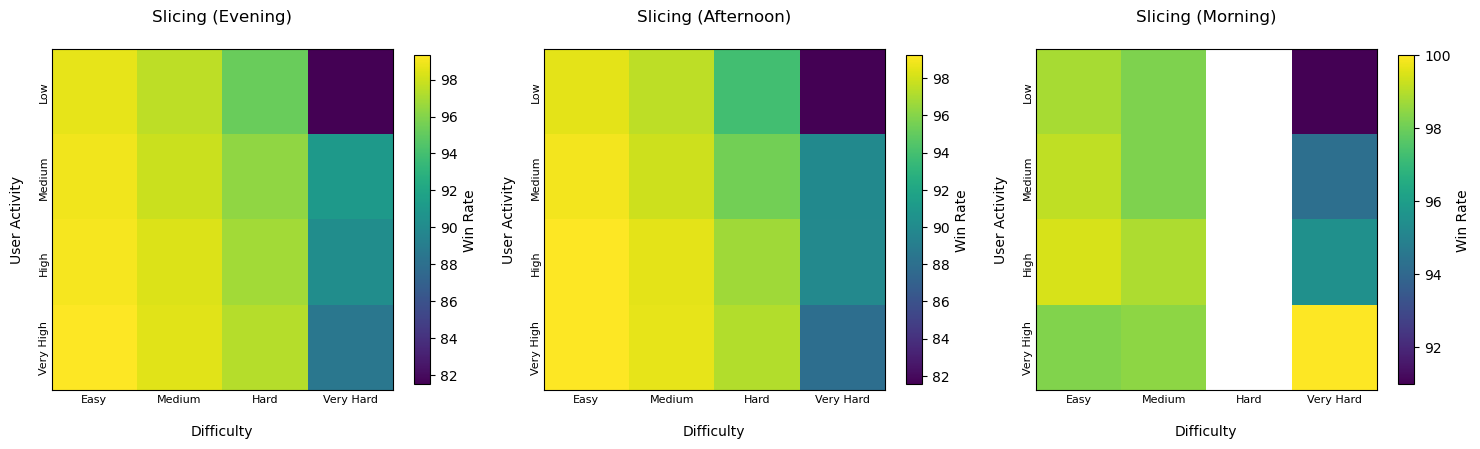

In [148]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot first image
im1 = axs[0].imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    axs[0].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[0].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[0].set_xlabel('Difficulty', labelpad=25)
axs[0].set_ylabel('User Activity', labelpad=20)
axs[0].set_title('Slicing (Evening)', pad=20)
fig.colorbar(im1, ax=axs[0], label='Win Rate', shrink=0.7)
axs[0].set_yticks([])
axs[0].set_xticks([])

# Plot second image
im2 = axs[1].imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    axs[1].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[1].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[1].set_xlabel('Difficulty', labelpad=25)
axs[1].set_ylabel('User Activity', labelpad=20)
axs[1].set_title('Slicing (Afternoon)', pad=20)
fig.colorbar(im2, ax=axs[1], label='Win Rate', shrink=0.7)
axs[1].set_yticks([])
axs[1].set_xticks([])

# Plot third image
im3 = axs[2].imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    axs[2].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[2].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[2].set_xlabel('Difficulty', labelpad=25)
axs[2].set_ylabel('User Activity', labelpad=20)
axs[2].set_title('Slicing (Morning)', pad=20)
fig.colorbar(im3, ax=axs[2], label='Win Rate', shrink=0.7)
axs[2].set_yticks([])
axs[2].set_xticks([])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Facendo dicing verifichiamo la decrescita del tasso di vincinta per gli utenti poco attivi (_Low Activity_) e gli utenti molto attivi (_Very High Activity_) consideando come fascia oraria la sera.

In [149]:
print(OLAP[0, 2, :])
print(OLAP[3, 2, :])

[98.62552473 97.53104417 95.23254685 81.48188743]
[99.31563511 98.49756098 97.30397663 88.5583524 ]


Possiamo notare come la decrescita del tasso di vincita sia più attenuata nel caso di utenti molto attivi e come il divario nel tasso di vincinta aumenti all'aumentare della difficoltà delle parole. Visualizziamo questa informazone con un grafico a linea.

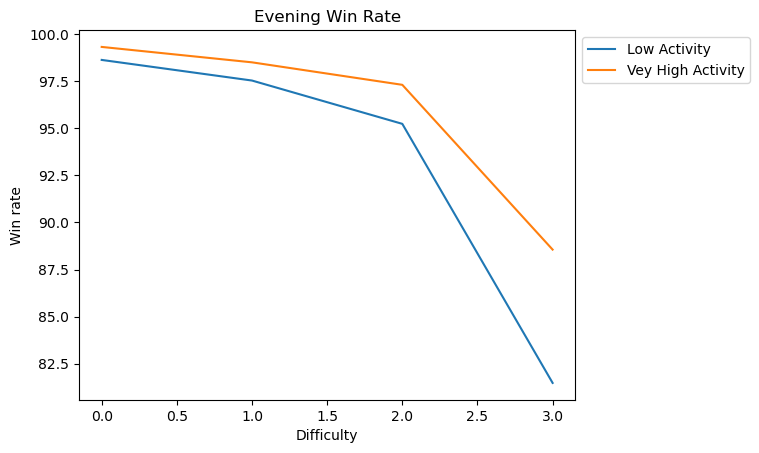

In [150]:
plt.xlabel('Difficulty')
plt.ylabel('Win rate')
plt.title('Evening Win Rate')
plt.plot(OLAP[0, 2, :], label='Low Activity') 
plt.plot(OLAP[3, 2, :], label='Vey High Activity') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show() 

## Test statistici

### Test 1

Utilizziamo un T-test.

Ipotesi nulla: gli utenti poco attivi in caso di vittoria si comportano allo stesso modo degli utenti attivi/molto attivi in termini di numero medio di tentativi.

Ipotesi alternativa: gli utenti poco attivi in caso di vittoria non si comportano allo stesso modo degli utenti attivi/molto attivi in termini di numero medio di tentativi.

Prendiamo come livello di significatività 0.05. Sussiste una differenza statisticamente significativa?

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.


Stampiamo il numero di elementi per le due classi. 

In [151]:
total_population = len(wordle)
print(total_population)

winning_attempts_low_activity = wordle.loc[(wordle['UserActivity'] == 'Low Activity') & (wordle['Win'] == 1), 'Attempts']
winning_attempts_high_activity = wordle.loc[(wordle['UserActivity'] == 'High Activity') & (wordle['Win'] == 1), 'Attempts']
print(len(winning_attempts_low_activity))
print(len(winning_attempts_high_activity))
print(len(winning_attempts_high_activity)+len(winning_attempts_low_activity))

test_winning_attempts_low_activity = winning_attempts_low_activity.sample(n=30000)
test_winning_attempts_high_activity = winning_attempts_high_activity.sample(n=30000)

if len(test_winning_attempts_low_activity) >= 30 and len(test_winning_attempts_high_activity) >= 30:
    print("Sample size condition (n ≥ 30) is met for both groups.")
else:
    print("Sample size condition (n ≥ 30) is not met for both groups.")

if total_population >= 10 * (len(test_winning_attempts_low_activity)) and total_population >= 10 *(len(test_winning_attempts_high_activity)):
    print("Population size condition (N ≥ 10n) is met for both groups.")
else:
    print("Population size condition (N ≥ 10n) is not met for both groups.")

2003628
385692
1032598
1418290
Sample size condition (n ≥ 30) is met for both groups.
Population size condition (N ≥ 10n) is met for both groups.


La prima condizione è soddisfatta, la seconda???

In [152]:
#t_value, p_value = stats.ttest_ind(winning_attempts_low_activity, winning_attempts_high_activity)
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity)

print("p-value:", p_value)

p-value: 1.007532232824597e-257


Essendo il p-value minore del livello di significatività, possiamo rigettare l'ipotesi nulla. Possiamo concludere che l'andamento di una partita in caso di vittoria per gli utenti poco attivi NON è lo stesso andamento di una partita in caso di vittoria per gli utenti attivi.

In [153]:
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity, alternative='greater')

print("p-value:", p_value)

p-value: 1.0


Essendo il p-value maggiore del livello di significatività, non possiamo rigettare l'ipotesi nulla. L'ipotesi nulla è che la media dei tentativi in caso di vittoria degli utenti poco attivi è maggiore della media dei tentativi in caso di vittoria degli utenti attivi. 

In [154]:
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity, alternative='less')

print("p-value:", p_value)

p-value: 5.037661164122985e-258


Essendo il p-value minore del livello di significatività, possiamo rigettare l'ipotesi nulla. Possiamo concludere che la media dei tentativi in caso di vittoria per gli utenti poco attivi NON è minore della media dei tentativi in caso di vittoria per gli utenti attivi.

### Test 2


Siccome circa la metà dei tweet provengono dal Client di iPhone, proviamo a impostare un T-Test con le seguente ipotesi
- $H_0$ = gli utenti che twittano da iPhone hanno la stesso media dei tentativi rispetto all'intera popolazione
- $H_a$ = gli utenti che twittano da iPhone hanno una media di tentativi diversa da quella generale

In [155]:
iphone_users_attempts = wordle.loc[(wordle['Source'] == 'Twitter for iPhone'), 'Attempts']
other_users_attempts = other_users_attempts = wordle.loc[wordle['Source'] != 'Twitter for iPhone', 'Attempts']
print(len(iphone_users_attempts))
print(len(other_users_attempts))

# Esegui il test t-student per un campione
statistica_t, valore_p = stats.ttest_ind(iphone_users_attempts, other_users_attempts)

# Stampa i risultati del test
print("Statistiche t:", statistica_t)
print("Valore p:", valore_p)

1126618
877010
Statistiche t: -25.258827861871413
Valore p: 9.532579257057782e-141


## Metodi Predittivi

### Regressione Lineare

A partire dal DataFrame _wordle_ creiamo un DataFrame _user_stats_ dove ogni riga conterrà le informazioni relative a un singolo utente.

In [156]:
num_tweets_by_user = wordle.groupby('UserID')['ID'].count().reset_index()
num_tweets_by_user.columns = ['UserID', 'Num_tweets']

user_wins = wordle[wordle['Win'] == True].groupby('UserID').size().reset_index(name='User_Wins')

# Merge the two dataframes on 'UserID'
user_stats = pd.merge(num_tweets_by_user, user_wins, on='UserID', how='left')

user_stats['User_Wins'] = user_stats['User_Wins'].fillna(0)

total_attempts_by_user = wordle.groupby('UserID')['Attempts'].sum().reset_index()
total_attempts_by_user.columns = ['UserID', 'Total_Attempts']

# Merge the new dataframe with user_stats on 'UserID'
user_stats = pd.merge(user_stats, total_attempts_by_user, on='UserID')

user_stats['User_Win_Rate'] = (user_stats['User_Wins'] / user_stats['Num_tweets'])*100

hard_mode_count_by_user = wordle.groupby('UserID')['Hard Mode'].sum().rename('Hard_Mode_Count')

# Update user_stats dataframe with the counts
user_stats = user_stats.set_index('UserID').join(hard_mode_count_by_user, how='left').reset_index()

# Fill NaN values with 0 if necessary
user_stats['Hard_Mode_Count'] = user_stats['Hard_Mode_Count'].fillna(0)

wordle_wins = wordle[wordle['Win']]

# Group the filtered DataFrame by 'UserID' and 'Attempts', and count occurrences
user_attempts_counts = wordle_wins.groupby(['UserID', 'Attempts']).size().reset_index(name='Attempts_Count')

# Pivot the grouped DataFrame to reshape it
user_attempts_pivot = user_attempts_counts.pivot(index='UserID', columns='Attempts', values='Attempts_Count').reset_index()

# Rename the columns to '1_attempts', '2_attempts', ..., '6_attempts'
user_attempts_pivot.columns = ['UserID', '1_attempts_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

# Merge with user_stats DataFrame on 'UserID' column
user_stats = pd.merge(user_stats, user_attempts_pivot, on='UserID', how='left')

# Fill NaN values with 0
user_stats = user_stats.fillna(0)

columns_to_convert = ['1_attempts_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

# Convert columns to integers
for col in columns_to_convert:
    user_stats[col] = user_stats[col].astype(int)


In [157]:
user_stats.head()

,UserID,Num_tweets,User_Wins,Total_Attempts,User_Win_Rate,Hard_Mode_Count,1_attempts_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win
0,187.0,1,1.0,2,100.0,0,0,1,0,0,0,0
1,422.0,1,1.0,4,100.0,1,0,0,0,1,0,0
2,521.0,3,3.0,16,100.0,0,0,0,0,1,0,2
3,556.0,5,5.0,19,100.0,0,0,0,2,2,1,0
4,765.0,18,18.0,75,100.0,0,0,0,5,8,2,3


Verifichiamo che non contenga valori nulli.

In [158]:
user_stats.isnull().sum()

UserID             0
Num_tweets         0
User_Wins          0
Total_Attempts     0
User_Win_Rate      0
Hard_Mode_Count    0
1_attempts_Win     0
2_attempts_Win     0
3_attempts_Win     0
4_attempts_Win     0
5_attempts_Win     0
6_attempts_Win     0
dtype: int64

A partire dal DataFrame _wordle_ creiamo un DataFrame _wordle_summary_ dove ogni riga conterrà le informazioni relative a una singola parola.

In [159]:
# Count the number of games for each WordleID
games_by_wordle = wordle.groupby('WordleID')['ID'].count().reset_index()
games_by_wordle.columns = ['WordleID', 'Number_of_Games']

# Count the number of wins for each WordleID
wins_by_wordle = wordle[wordle['Win'] == True].groupby('WordleID')['Win'].count().reset_index()
wins_by_wordle.columns = ['WordleID', 'Number_of_Wins']

# Merge the two DataFrames on 'WordleID'
wordle_summary = pd.merge(games_by_wordle, wins_by_wordle, on='WordleID', how='left').fillna(0)

winning_attempts = wordle[wordle['Win'] == True]

# Group the filtered DataFrame by 'WordleID' and calculate the mean of 'Attempts'
mean_attempts_by_wordleid = winning_attempts.groupby('WordleID')['Attempts'].mean().reset_index()

# Merge the mean attempts data with the 'wordle_summary' DataFrame
wordle_summary = wordle_summary.merge(mean_attempts_by_wordleid, on='WordleID', how='left')

# Rename the new column to indicate it contains mean attempts for victories
wordle_summary.rename(columns={'Attempts': 'Mean_Attempts_Victory'}, inplace=True)

wordle_summary['Win_Rate'] = (wordle_summary['Number_of_Wins'] / wordle_summary['Number_of_Games'])*100

hard_mode_counts = wordle[wordle['Hard Mode']].groupby('WordleID').size().reset_index(name='Hard_Mode_Count')

# Merge the counts with the wordle_summary DataFrame
wordle_summary = pd.merge(wordle_summary, hard_mode_counts, on='WordleID', how='left')

# Fill NaN values in the new column with 0
wordle_summary['Hard_Mode_Count'] = wordle_summary['Hard_Mode_Count'].fillna(0)

wordle_win = wordle[wordle['Win']]

# Group by WordleID and Attempts, and count the occurrences
attempts_counts = wordle_win.groupby(['WordleID', 'Attempts']).size().unstack(fill_value=0)

# Rename the columns
attempts_counts.columns = ['1_attempt_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

# Merge with wordle_summary dataframe on WordleID
wordle_summary = pd.merge(wordle_summary, attempts_counts, on='WordleID', how='left')

wordle_summary = wordle_summary.fillna(0)

In [160]:
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,1_attempt_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345


Verifichiamo che non contenga valori nulli.

In [161]:
wordle_summary.isnull().sum()

WordleID                 0
Number_of_Games          0
Number_of_Wins           0
Mean_Attempts_Victory    0
Win_Rate                 0
Hard_Mode_Count          0
1_attempt_Win            0
2_attempts_Win           0
3_attempts_Win           0
4_attempts_Win           0
5_attempts_Win           0
6_attempts_Win           0
dtype: int64

Verifichiamo che ci sia coerenza tra _wordle_,_user_stats_ e _wordle_summary_.

In [162]:
total_hard_mode_wordle_summary = wordle_summary['Hard_Mode_Count'].sum()
total_hard_mode_user_stats = user_stats['Hard_Mode_Count'].sum()
total_win_user_stats = user_stats['User_Wins'].sum()
total_win = wordle['Win'].sum()
total_hard_mode_count = hard_mode_count_by_user.sum()

print("Total Hard Mode Count in user_stats:", total_hard_mode_user_stats)
print("Total Hard Mode Count in wordle_summary:", total_hard_mode_wordle_summary)
print("Total Hard Mode Count:", total_hard_mode_count)
print("Total Win Count in user_stats:", total_win_user_stats)
print("Total Win Count in wordle:", total_win)
print("Number of users:", user_stats.shape[0])
print("Wordle number of users:", wordle['UserID'].nunique())

Total Hard Mode Count in user_stats: 120660
Total Hard Mode Count in wordle_summary: 120660
Total Hard Mode Count: 120660
Total Win Count in user_stats: 1952040.0
Total Win Count in wordle: 1952040
Number of users: 406523
Wordle number of users: 406523


Supponiamo di voler stimare una funzione che preveda il numero di condivisioni vincenti di un utente a partire dal suo numero complessivo di condivisioni. Prima di tutto possiamo utilizzare una rappresentazione grafica per verificare se le due features siano correlate, e se sia quindi possibile utilizzare una di queste features per predire l'altra.

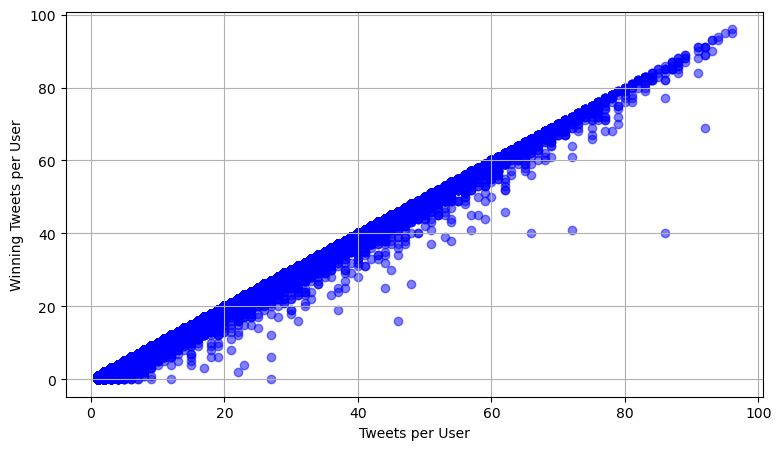

In [163]:
plt.figure(figsize=(9, 5))
plt.scatter(user_stats['Num_tweets'], user_stats['User_Wins'], color='blue', alpha=0.5)
plt.xlabel('Tweets per User')
plt.ylabel('Winning Tweets per User')
plt.grid(True)

plt.show()

In [164]:
r = user_stats[['Num_tweets', 'User_Wins']].corr()
print(r)

            Num_tweets  User_Wins
Num_tweets    1.000000   0.998374
User_Wins     0.998374   1.000000


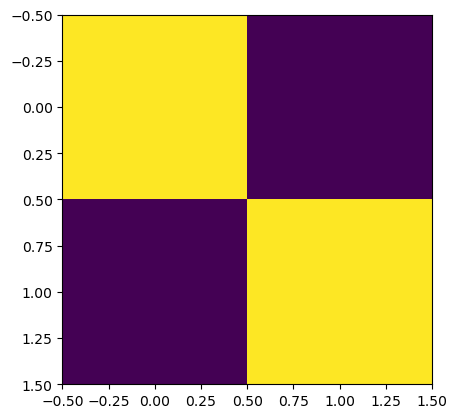

In [165]:
plt.imshow(r)

In [166]:
from sklearn.model_selection import train_test_split

features = ['Num_tweets']
X = user_stats[features]
Y = user_stats['User_Wins']

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2)

Text(0, 0.5, 'Number of Winning Tweets')

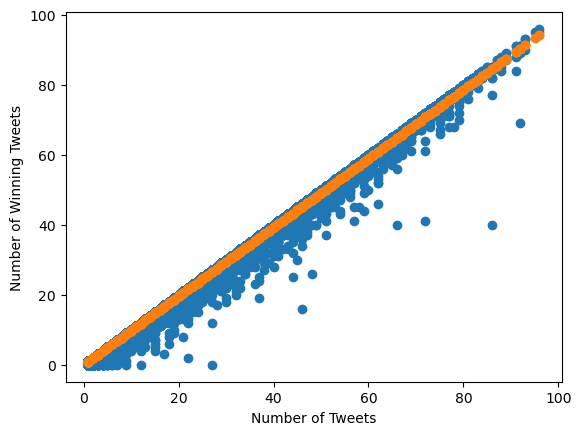

In [167]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
reg = regressor.fit(X_train, y_train)

#scriviamo la retta 
y_pred_train = reg.coef_*X_train + reg.intercept_
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred_train)
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Winning Tweets')

Text(0, 0.5, 'Number of Winning Tweets')

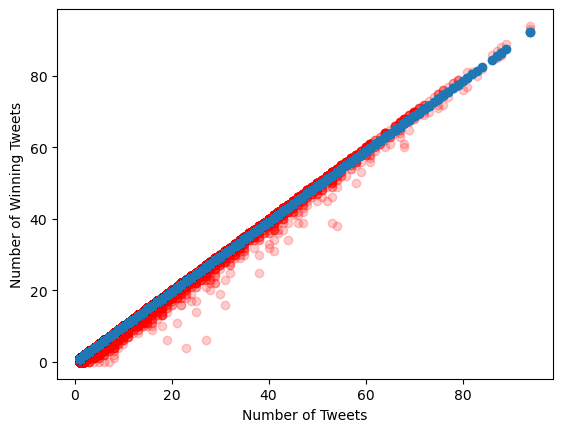

In [168]:
y_hat = reg.predict(X_valid)
plt.scatter(X_valid,y_valid,c='r',alpha=0.2)
plt.scatter(X_valid,y_hat)
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Winning Tweets')

Implementiamo le funzioni per il calcolo dell'MSE, dell'MAE e del RMSE: ci serviranno per valutare se il modello ottenuto è accettabile o meno.

In [169]:
# sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> MSE
def MSE (y_pred,y_true):
   return 1/y_pred.shape[0] * np.abs((y_pred-y_true)).sum()

# sommatoria del valore assoluto della differenza tra y vera e y predetta diviso il numero di y -> MAE
def MAE (y_pred,y_true):
     return 1/y_pred.shape[0] * ((y_pred-y_true)**2).sum()

# radice della sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> RMSE
def RMSE (y_pred,y_true):
     return np.sqrt(1/y_pred.shape[0] * ((y_pred-y_true)**2).sum())

Abbiamo visto che ci sono tre metriche per valutare i modelli a regressione di machine learning:

- lo scarto medio assoluto (MAE - Mean Absolute Error);
- l’errore quadratico medio (MSE - Mean Squared Error);
- la radice dell’errore quadratico medio (RMSE - Root of Mean Squared Error).

In [170]:
print("MAE: ", MAE(y_hat, y_valid))
print("MSE: ",MSE(y_hat, y_valid))
print("RMSE: ",RMSE(y_hat, y_valid))

MAE:  0.20271550624677034
MSE:  0.2098141785934809
RMSE:  0.45023938771143773


Per verificare che il risultato ottenuto sia un buon risultato ricorriamo al modello nullo. L'errore del modello nullo deve essere maggiore dell'errore del modello che abbiamo ottenuto per poter dire di aver ottenuto un modello accettabile.

In [171]:
mean_num_tweets = y_valid.mean()

null_model_y = np.ones(len(y_valid))*mean_num_tweets

print("MSE modello nullo: ", MSE(null_model_y, y_valid))

MSE modello nullo:  4.793928555837851


### Regressione Logistica

***Inizio Errore***

In [172]:
from sklearn.linear_model import LogisticRegression
#codice qui
y = wordle['Win']
x = wordle[['Attempts']]
print(np.sum(y==1))
print(np.sum(y==0))
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)
print(y_pred)
print(reg.score(x_valid, y_valid))

1952040
51588
[ True  True  True ...  True  True  True]
0.9742816787530632


In [173]:
classe1 = np.sum(y_valid ==1)/x_valid.shape[0]
classe0 = np.sum(y_valid==0)/x_valid.shape[0]
print(classe0)
print(classe1)

0.02571832124693681
0.9742816787530632


***Fine Errore***

Passiamo ora alla Regressione Logistica.

Supponiamo di voler stimare una curva separatrice che preveda se il numero di condivisioni vincenti per una certa parola è superiore o inferiore alla media a partire dal numero di condivisioni complessivo per la stessa. 

In [174]:
mean_value = wordle_summary['Number_of_Wins'].mean()
wordle_summary['above_average'] = (wordle_summary['Number_of_Wins']>mean_value).astype(int)
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,1_attempt_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win,above_average
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152,1
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585,0
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104,1
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536,1
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345,1


In [175]:
from sklearn.linear_model import LogisticRegression
#codice qui
y = wordle_summary['above_average']
x = wordle_summary[['Number_of_Games']]
print(np.sum(y==1))
print(np.sum(y==0))
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)
print(y_pred)
print(reg.score(x_valid, y_valid))

79
28
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
0.8636363636363636


Siamo riusciti a raggiungere un'accuratezza superiore all'80% con un modello di Logistic Regression. Quale sarebbe un opportuno modello nullo per confrontare?
Possiamo immaginare di predire sempre la classe più comune. 

In [176]:
classe1 = np.sum(y_valid ==1)/x_valid.shape[0]
classe0 = np.sum(y_valid==0)/x_valid.shape[0]
print(classe0)
print(classe1)

0.22727272727272727
0.7727272727272727


Abbiamo definito e ottenuto un modello più accurato del modello nullo. 

## Clustering

Realizziamo uno scatter plot.

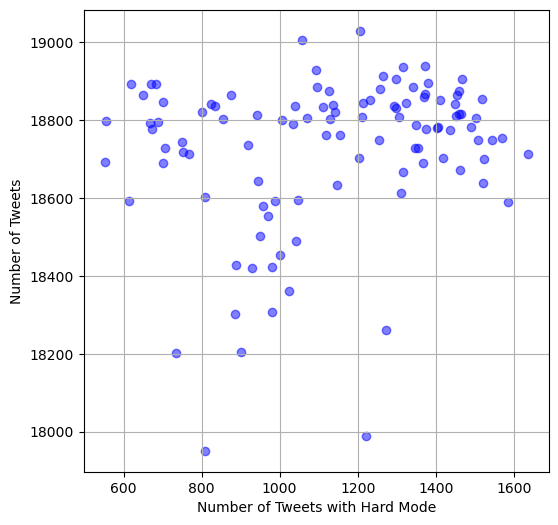

In [177]:
plt.figure(figsize=(6, 6))
plt.scatter(wordle_summary['Hard_Mode_Count'], wordle_summary['Number_of_Games'], color='blue', alpha=0.5)
plt.ylabel("Number of Tweets")
plt.xlabel("Number of Tweets with Hard Mode")
plt.grid(True)
plt.show()

Ricorrendo all'algoritmo K-Means, effettuiamo diverse operazioni di clustering, una per ogni valore di k compreso tra 2 e 11. Per ciascuna di queste valutiamo la qualità del risultato calcolando il coefficiente di Silhoutte. 

In [178]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def clustering_test(n, df, feature_cols): 
   
    kmeans = KMeans(n_clusters=n, random_state=42)
    
    X = df[feature_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
   
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

silhouttes_for_nclusters = []
cols = ['Hard_Mode_Count', 'Number_of_Games']

for i in range (2, 11): 
    silhouttes_for_nclusters.append((i,clustering_test(i, wordle_summary, cols)))

Stampiamo i coefficienti di Silhouette ottenuti e visualizziamoli in un grafico a linea.

In [179]:
print(silhouttes_for_nclusters)

[(2, 0.5088863474612634), (3, 0.53173431403586), (4, 0.48413677962490487), (5, 0.45446075513817863), (6, 0.3916004395261418), (7, 0.34325095132934635), (8, 0.3867560022733923), (9, 0.34645753856614864), (10, 0.36239134127686534)]


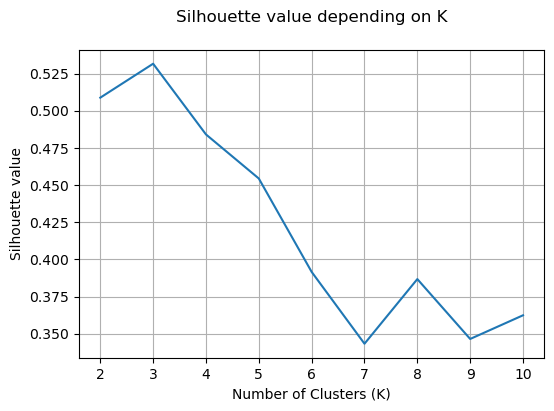

In [180]:
num_cluster = [x[0] for x in silhouttes_for_nclusters]
silhouette_scores = [x[1] for x in silhouttes_for_nclusters]

plt.figure(figsize=(6, 4))
plt.plot(num_cluster, silhouette_scores, linestyle='-')
plt.title('Silhouette value depending on K', pad=20)
plt.ylabel('Silhouette value')
plt.xlabel('Number of Clusters (K)')
plt.grid(True)
plt.show()

Il risultato con coefficiente di Silhouette massimo è il migliore: determiniamo quale esso sia.

In [181]:
best_cluster = max(silhouttes_for_nclusters, key=lambda x: x[1])
print(best_cluster)

(3, 0.53173431403586)


Visualizziamo con tre scatter plot il clustering ottenuto con il k migliore e con i due valori ad esso adiacenti.

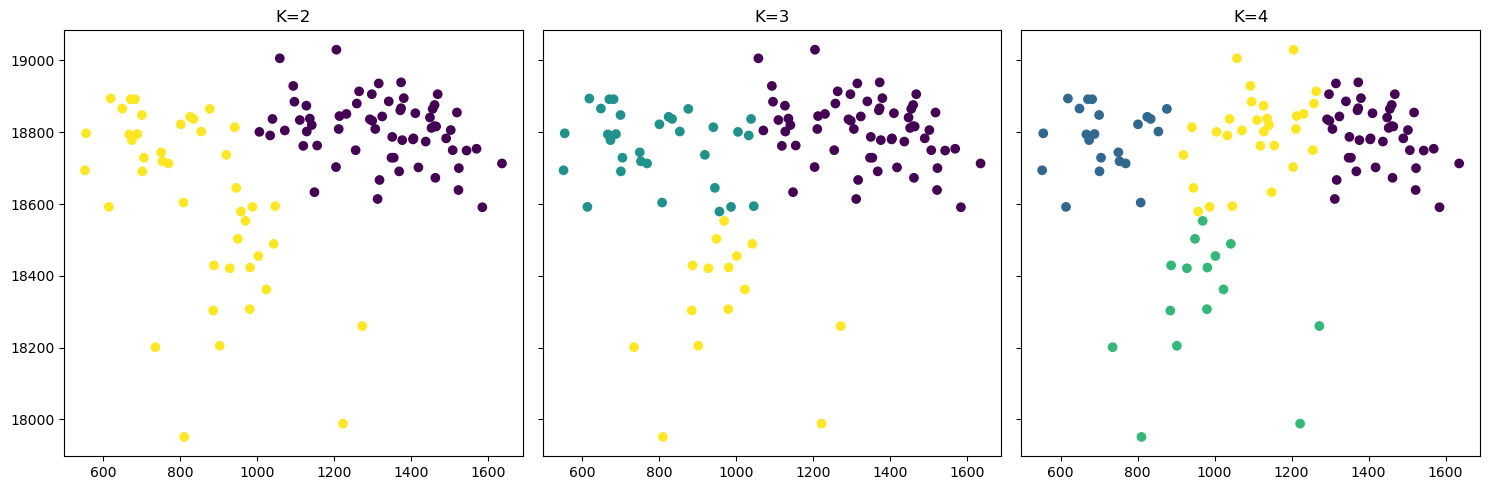

In [182]:
def plot_clustering(n, ax, df, feature_cols):
    if n != 1:
        
        kmeans = KMeans(n_clusters=n, random_state=24)
        
        X = df[feature_cols]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        kmeans.fit(X_scaled)
        
        cluster_labels = kmeans.labels_
        
        df['Cluster'] = cluster_labels
        
        ax.scatter(df[feature_cols[0]], df[feature_cols[1]], c=df['Cluster'], cmap='viridis')

        df.drop(columns=['Cluster'], inplace=True)

bestk = best_cluster[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  

# Call plot_clustering() with different number of clusters
plot_clustering(bestk-1, axs[0], wordle_summary, cols)
axs[0].set_title('K={}'.format(bestk-1))

plot_clustering(bestk, axs[1], wordle_summary, cols)
axs[1].set_title('K={}'.format(bestk))

plot_clustering(bestk+1, axs[2], wordle_summary, cols)
axs[2].set_title('K={}'.format(bestk+1))

plt.tight_layout() 
plt.show()

## Clustering pt2

### Passaggio a dati puramente numerici

In [214]:
wordle_clustering = wordle.copy()  # creo una copia del dataset per il clustering
wordle_clustering.sample(10).head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity,TimeOfDay,Difficulty
257036,266,1502720714020986891,2022-03-12 18:58:32+00:00,Twitter for Android,1.275764e+18,5,False,"[⬛🟨⬛🟩⬛, ⬛🟩⬛⬛🟨, ⬛⬛⬛⬛⬛, 🟨⬛🟨⬛⬛, 🟩🟩🟩🟩🟩]",True,Low Activity,Afternoon,Easy
734603,290,1511039499878662144,2022-04-04 17:54:25+00:00,Other,5.659949e+08,5,False,"[⬛🟨🟨⬛🟨, ⬛⬛⬛⬛⬛, ⬛⬛🟨🟩🟩, 🟩🟩⬛🟩🟩, 🟩🟩🟩🟩🟩]",True,Low Activity,Afternoon,Hard
1017382,305,1516798172168863748,2022-04-20 15:17:19+00:00,Twitter for iPhone,4.130168e+09,3,False,"[⬛⬛🟨🟨⬛, 🟩🟩🟩🟨⬛, 🟩🟩🟩🟩🟩]",True,Medium Activity,Afternoon,Medium
839757,295,1513186998890213379,2022-04-10 16:07:48+00:00,Twitter for Android,2.210354e+07,3,False,"[⬛⬛🟩⬛⬛, ⬛🟩🟩⬛⬛, 🟩🟩🟩🟩🟩]",True,High Activity,Afternoon,Easy
237315,265,1502366596391747587,2022-03-11 19:31:23+00:00,Twitter for iPhone,1.638342e+09,6,False,"[⬛⬛🟨🟩🟩, ⬛🟩🟩🟩🟩, ⬛🟩🟩🟩🟩, ⬛🟩🟩🟩🟩, ⬛🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]",True,Low Activity,Evening,Very Hard


La colonna match per il clustering può essere utilizzata estraendo la quantità di quadratini per i vari colori utilizzati in ogni match, dopo aver estratto l'informazione possiamo eliminare la colonna match

In [215]:

# Function to count occurrences of each type of square emoji
def count_squares(emojis):
    green = 0
    yellow = 0
    black = 0
    white = 0
    for emoji_list in emojis:
        green += emoji_list.count('🟩')
        yellow += emoji_list.count('🟨')
        black += emoji_list.count('⬛')
        white += emoji_list.count('⬜')
    black_white = black + white
    return green, yellow, black_white

# Apply the function to 'Match' column and create new columns
wordle_clustering['Green_Count'], wordle_clustering['Yellow_Count'], wordle_clustering['BlackWhite_Count'] = zip(*wordle_clustering['Match'].apply(count_squares))

wordle_clustering.drop(columns=['Match'], axis = 1, inplace=True) # rimuovo la colonna

wordle_clustering.sample(10).head(10)

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
1696871,347,1531985214716510208,2022-06-01 13:05:12+00:00,Twitter for iPhone,1.135851e+18,6,False,True,Medium Activity,Afternoon,Medium,11,9,10
204173,264,1502048434156670978,2022-03-10 22:27:08+00:00,Twitter for iPhone,5.832310e+07,5,False,True,High Activity,Evening,Easy,12,3,10
598137,283,1508500546247806978,2022-03-28 17:45:31+00:00,Other,1.077758e+08,4,False,True,Low Activity,Afternoon,Medium,10,2,8
389008,273,1505273709774491648,2022-03-19 20:03:13+00:00,Twitter for iPhone,2.577760e+08,6,False,True,Medium Activity,Evening,Medium,9,5,16
1611331,339,1529117993380225027,2022-05-24 15:11:53+00:00,Twitter for iPhone,1.441148e+18,3,False,True,High Activity,Afternoon,Medium,7,4,4
1088070,309,1518301236658847745,2022-04-24 18:49:58+00:00,Twitter for iPhone,2.266820e+09,3,False,True,High Activity,Afternoon,Easy,8,1,6
2098984,374,1541735639284158467,2022-06-28 10:49:55+00:00,Twitter for iPhone,8.249774e+17,5,False,True,High Activity,Morning,Medium,10,3,12
2063694,372,1541138379927986177,2022-06-26 19:16:37+00:00,Twitter for Android,6.662175e+07,4,False,True,High Activity,Evening,Easy,6,7,7
401808,274,1505682047720775682,2022-03-20 23:05:49+00:00,Twitter for iPad,3.682560e+07,4,True,True,Medium Activity,Evening,Medium,9,2,9
2058638,371,1540650878511845377,2022-06-25 10:59:28+00:00,Twitter Web App,2.599268e+09,5,False,True,Very High Activity,Morning,Medium,9,5,11


Iniziamo a preparare il nostro dataset per il clustering, convertiamo le colonne HardMode e Win da Booleane a interi, 1 quando si ha True e 0 quando si ha false

In [216]:
wordle_clustering['Hard Mode'] = wordle_clustering['Hard Mode'].astype(int)
wordle_clustering['Win'] = wordle_clustering['Win'].astype(int)
wordle_clustering.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,36816757.0,3,0,1,Low Activity,Evening,Easy,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,482591014.0,4,0,1,High Activity,Evening,Easy,9,0,11
73387,257,1499477529232617480,2022-03-03 20:11:16+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,Evening,Easy,8,5,12
133607,260,1500563244653678592,2022-03-06 20:05:31+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,Evening,Easy,11,1,13
161136,262,1501340165331202049,2022-03-08 23:32:43+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,Evening,Medium,10,3,12


Ora iniziamo a convertire i valori qualitativi in valori quantitativi tramite una codifica ordinale, iniziamo da TimeOfDay, in ordine crescente in base al momento del giorno

In [217]:
ordinal_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
wordle_clustering['TimeOfDay'] = wordle_clustering['TimeOfDay'].map(ordinal_mapping)
wordle_clustering.head()


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,36816757.0,3,0,1,Low Activity,3,Easy,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,482591014.0,4,0,1,High Activity,3,Easy,9,0,11
73387,257,1499477529232617480,2022-03-03 20:11:16+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,3,Easy,8,5,12
133607,260,1500563244653678592,2022-03-06 20:05:31+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,3,Easy,11,1,13
161136,262,1501340165331202049,2022-03-08 23:32:43+00:00,Twitter for iPhone,482591014.0,5,0,1,High Activity,3,Medium,10,3,12


Analogamente si fa per Source, UserActivity, Difficulty

In [218]:
# UserActivity
ordinal_mapping = {'Low Activity': 1, 'Medium Activity': 2, 'High Activity': 3, 'Very High Activity': 4}
wordle_clustering['UserActivity'] = wordle_clustering['UserActivity'].map(ordinal_mapping)
# Source
ordinal_mapping = {'Twitter for iPhone' : 1, 'Twitter for Android' : 2, 'Twitter Web App' : 3, 'Twitter for iPad' : 4, 'Other' : 5, 'TweetDeck' : 6}
wordle_clustering['Source'] = wordle_clustering['Source'].map(ordinal_mapping)
# Difficulty
ordinal_mapping = {'Easy':1, 'Medium':2, 'Hard':3, 'Very Hard':4}
wordle_clustering['Difficulty'] = wordle_clustering['Difficulty'].map(ordinal_mapping)

wordle_clustering.head()



,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,1,36816757.0,3,0,1,1,3,1,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,1,482591014.0,4,0,1,3,3,1,9,0,11
73387,257,1499477529232617480,2022-03-03 20:11:16+00:00,1,482591014.0,5,0,1,3,3,1,8,5,12
133607,260,1500563244653678592,2022-03-06 20:05:31+00:00,1,482591014.0,5,0,1,3,3,1,11,1,13
161136,262,1501340165331202049,2022-03-08 23:32:43+00:00,1,482591014.0,5,0,1,3,3,2,10,3,12


Siccome Created_At non aggiunge ulteriori informazioni, dato che WordleID indica in un certo senso il giorno e l'orario è presente nella colonna TimeOfDay, quindi decidiamo di eliminare questa colonna

In [219]:
wordle_clustering.drop(columns=['Created_At'], axis = 1, inplace=True) # rimuovo la colonna
wordle_clustering.head()


,WordleID,ID,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,1,36816757.0,3,0,1,1,3,1,6,4,5
1,254,1498447918184996864,1,482591014.0,4,0,1,3,3,1,9,0,11
73387,257,1499477529232617480,1,482591014.0,5,0,1,3,3,1,8,5,12
133607,260,1500563244653678592,1,482591014.0,5,0,1,3,3,1,11,1,13
161136,262,1501340165331202049,1,482591014.0,5,0,1,3,3,2,10,3,12


### Normalizzazione

In [223]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(wordle_clustering)

# visualizziamo la normalizzazione
X_scaled.view()

array([[0.        , 0.00142585, 0.        , ..., 0.24      , 0.15384615,
        0.16666667],
       [0.        , 0.00142578, 0.        , ..., 0.36      , 0.        ,
        0.36666667],
       [0.02068966, 0.02099226, 0.        , ..., 0.32      , 0.19230769,
        0.4       ],
       ...,
       [1.        , 0.99529925, 0.6       , ..., 0.48      , 0.03846154,
        0.23333333],
       [1.        , 0.99529825, 0.4       , ..., 0.28      , 0.38461538,
        0.26666667],
       [1.        , 0.99529701, 0.4       , ..., 0.28      , 0.11538462,
        0.16666667]])

### Clustering vero e prorio

In [ ]:
def clustering_test(n, df, feature_cols): 
   
    kmeans = KMeans(n_clusters=n, random_state=42)
    
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
   
    silhouette_avg = silhouette_score(wordle_clustering, cluster_labels)
    return silhouette_avg

silhouttes_for_nclusters = []
cols = ['Hard_Mode_Count', 'Number_of_Games']

for i in range (2, 11): 
    silhouttes_for_nclusters.append((i,clustering_test(i, wordle_summary, cols)))